In [263]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [285]:
#define amount of sample points
N = 2000

In [286]:
#in the beginning we plot graph of the thermal conductivity process
def thermal_conductivity_equation(t, x):
    return (2 + torch.exp(-4*(torch.pi**2)*t)*torch.sin(2*torch.pi*x) + torch.exp(-16*(torch.pi**2)*t)*torch.cos(4*torch.pi*x))

In [299]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer=2, h1=64, h2=64, h3=64, output_layer=1):
        super().__init__()
        activation = nn.Tanh
        self.fc1 = nn.Linear(input_layer, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
#         self.fc4 = nn.Linear(h3, h4)
#         self.fc5 = nn.Linear(h4, h5)
        self.fc4 = nn.Linear(h3, output_layer)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = F.gelu(self.fc4(x))
#         x = F.gelu(self.fc5(x))
#         x = F.gelu(self.fc6(x))
        
        return x

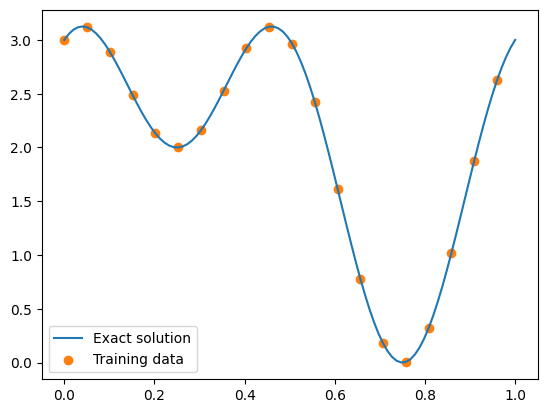

In [304]:
x = torch.linspace(0, 1, 100)
time = torch.zeros(100)
temp = thermal_conductivity_equation(time, x)

x_data = x[0:100:5]
temp_data = temp[0:100:5]


plt.plot(x, temp, label="Exact solution")
plt.scatter(x_data, temp_data, color="tab:orange", label="Training data")

plt.legend()
plt.show()

In [310]:
x_physics = torch.rand(N).view(-1, 1).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).view(-1, 1).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
points_data = torch.stack((torch.zeros(N, 1), x_physics), -1)


torch.manual_seed(123)

pinn_model = PINN()
optimizer = torch.optim.SGD(pinn_model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5000, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.6, patience=10)


In [313]:
epochs = 5000

prev_loss = 0
for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    og_temp = pinn_model.forward(points_data)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation(time_physics, x_physics) - og_temp)**2)
    loss2 = torch.mean((thermal_conductivity_equation(torch.zeros_like(x_physics), x_physics) - og_temp)**2)
    
    network_temp = pinn_model.forward(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True)[0]

    # computes dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    
    
    loss = loss1 + loss2 + loss3
    loss.backward(retain_graph=True)
    
    """
    custom scheduler
    """
    
#     if prev_loss == 0:
#         prev_loss = loss

#     if cur_epoch != 0 and cur_epoch % 10 == 0:
#         if prev_loss == loss:
#             optimizer.param_groups[0]['lr'] = 0.9
#         elif abs(prev_loss-loss) < 0.1:
#             optimizer.param_groups[0]['lr'] *= 1.5
#         else:
#             optimizer.param_groups[0]['lr'] = 0.1
#         optimizer.param_groups[0]['lr'] = min(optimizer.param_groups[0]['lr'], 0.5)
#         prev_loss = loss
        
    
    optimizer.step()
    scheduler.step(loss)
    
    if cur_epoch % 100 == 0:
        print(f'epoch: {cur_epoch}, loss: {loss}, learning_rate: {optimizer.param_groups[0]["lr"]}')
    

print(f'epoch: {cur_epoch}, loss: {loss}, learning_rate: {optimizer.param_groups[0]["lr"]}')
    
    

epoch: 0, loss: 1.1803929805755615, learning_rate: 0.001
epoch: 100, loss: 1.177251935005188, learning_rate: 0.001
epoch: 200, loss: 1.176811695098877, learning_rate: 4.665599999999999e-05
epoch: 300, loss: 1.1768041849136353, learning_rate: 4.7018498457599973e-07
epoch: 400, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 500, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 600, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 700, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 800, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 900, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 1000, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 1100, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 1200, loss: 1.1768041849136353, learning_rate: 2.1936950640377836e-08
epoch: 1300, loss: 1.1768041849136353, learning_

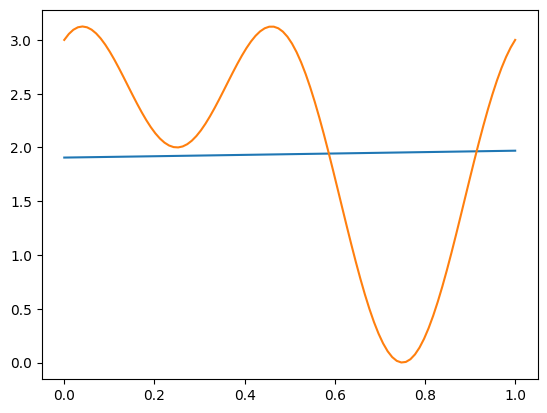

In [314]:
x = torch.linspace(0, 1, 100)
time = torch.zeros(100)
real_temp = thermal_conductivity_equation(time, x)

test_points = torch.stack((x, time), axis = -1)

pinn_temp = pinn_model(test_points)

plt.plot(x.detach(), pinn_temp.detach())
plt.plot(x, real_temp)

plt.plot()
plt.show()

In [ ]:
print(torch.zeros(N, 1))